# Train a simple neural network with Tensorflow

In [19]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

# Image librarie
from PIL import Image

# Filesystem
import json

# Other
import random
import os

print(tf.__version__)

env = open('env.json','r')
env = json.load(env)

1.13.1


## Load all images
Create a dataset of images composed of train dataset and test dataset. You can specify the number max of images you want to load in the parameter of function load_images at the bottom of the next cell.

Inb load_images, we choose nb_images (SECTION or SURFACE indicated in vue_of_image param) randomly taken in all images in images_directory. We put randomly each image in the train dataset or in the test dataset with a random distribution of 0.6 / 0.3.

At the end of loading, you can see how many of each class have been loaded in the whole dataset.

In [20]:
img_directory = env['dataset_path'] if env['dataset_path'] else "../dataset/"

def list_files_from_directory(directory = "./", extension = "jpg"):
    return list(f for f in os.listdir(directory) if f.endswith('.' + extension))

def load_images(nb_images = -1, vue_of_image = "SEC", img_directory = "./"):
    #On recupere la liste des chemins vers les images du dataset originale
    img_list = list_files_from_directory(directory = img_directory)
    random.shuffle(img_list)
    
    nb_original_img = len(img_list)
    if nb_images == -1:
        nb_images = nb_original_img
    
    #On itere sur toutes les images pour les chargers dans le dataset
    train_dataset = []
    train_labels = []
    test_dataset = []
    test_labels = []
    
    i = 0
    nb_ACI = 0
    nb_WED = 0
    nb_WHE = 0
    nb_autre = 0
    
    for img_path in img_list:
        test_or_train = random.random()
        add_image = False
        type_img = img_path.split("_")[0]
        vue = img_path.split("_")[1]
        if vue == vue_of_image:
            if type_img == "IIIb":
                label = 0
                add_image = True
                nb_ACI += 1
            elif type_img == "IIb":
                label = 1
                add_image = True 
                nb_WED += 1
            elif type_img == "Ia":
                label = 2
                add_image = True
                nb_WHE += 1
            else:
                label = 3
                add_image = True
                nb_autre += 1
        if add_image:
            i += 1
            img = np.array(Image.open(img_directory + img_path).resize((500, 500)))
            if test_or_train <= 0.6:
                train_dataset.append(img)
                train_labels.append(label)
            else:
                test_dataset.append(img)
                test_labels.append(label)
        if i >= nb_images:
            break
        
    print("IIIb : " + str(nb_ACI) + " IIb : " + str(nb_WED) + " Ia : " + str(nb_WHE) + " Autre : " + str(nb_autre))
    return np.array(train_dataset), np.array(train_labels), np.array(test_dataset), np.array(test_labels)

type_of_vue = "SUR"
(train_images, train_labels, test_images, test_labels) = load_images(-1, img_directory = img_directory, vue_of_image = type_of_vue)

IIIb : 17 IIb : 22 Ia : 29 Autre : 0


In [4]:
class_names = ['IIIb', 'IIb', 'Ia', 'Autre']

In [5]:
train_images.shape

(63, 500, 500, 3)

In [6]:
len(train_labels)

63

In [7]:
train_labels

array([1, 3, 3, 2, 3, 2, 2, 3, 3, 3, 2, 1, 2, 0, 0, 1, 3, 1, 0, 3, 3, 2,
       2, 3, 2, 3, 3, 1, 2, 3, 3, 3, 1, 3, 2, 3, 2, 0, 2, 0, 1, 1, 1, 2,
       0, 3, 3, 3, 3, 1, 3, 0, 2, 2, 0, 0, 2, 2, 2, 0, 2, 3, 0])

In [8]:
test_images.shape

(50, 500, 500, 3)

In [9]:
len(test_labels)

50

## Preprocess the data

The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

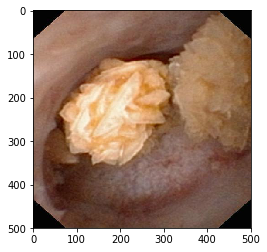

In [10]:
plt.figure()
plt.imshow(train_images[0])
plt.grid(False)

We scale these values to a range of 0 to 1 before feeding to the neural network model. For this, cast the datatype of the image components from an integer to a float, and divide by 255. Here's the function to preprocess the images:

It's important that the *training set* and the *testing set* are preprocessed in the same way:

In [11]:
for img in train_images:
    for px in img:
        px = px / 255.0

for img in test_images:
    for px in img:
        px = px / 255.0

train_images.shape

(63, 500, 500, 3)

Display the first 25 images from the *training set* and display the class name below each image. Verify that the data is in the correct format and we're ready to build and train the network.

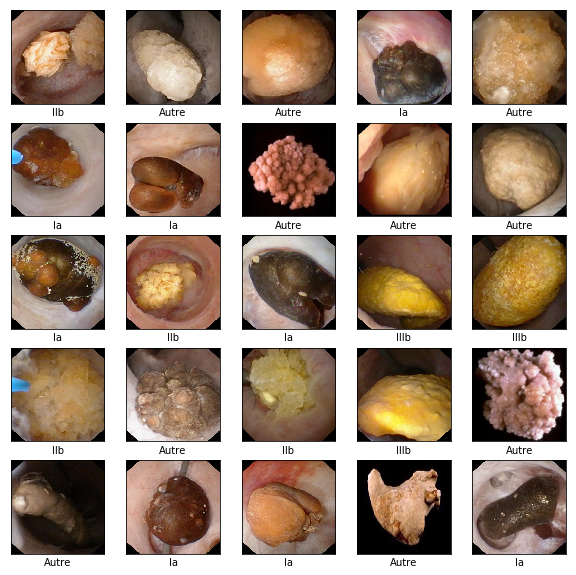

In [12]:
plt.figure(figsize=(10,10))
for i in range(min(25, len(train_images))):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Setup the layers

The basic building block of a neural network is the *layer*. Layers extract representations from the data fed into them. And, hopefully, these representations are more meaningful for the problem at hand.

Most of deep learning consists of chaining together simple layers. Most layers, like `tf.keras.layers.Dense`, have parameters that are learned during training.

In [13]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

model = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


The first layer in this network, `tf.keras.layers.Flatten`, transforms the format of the images from a 2d-array (of 28 by 28 pixels), to a 1d-array of 500 * 500 pixels. Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two `tf.keras.layers.Dense` layers. These are densely-connected, or fully-connected, neural layers. The first `Dense` layer has 128 nodes (or neurons). The second (and last) layer is a 3-node *softmax* layer—this returns an array of 3 probability scores that sum to 1. Each node contains a score that indicates the probability that the current image belongs to one of the 10 classes.

### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's *compile* step:

* *Loss function* —This measures how accurate the model is during training. We want to minimize this function to "steer" the model in the right direction.
* *Optimizer* —This is how the model is updated based on the data it sees and its loss function.
* *Metrics* —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [14]:
features = model.predict(train_images)

In [15]:
features.shape

(63, 15, 15, 512)

In [16]:
new_features = []
for feature in features:
    new_features.append(feature.flatten())
features = np.array(new_features)

In [17]:
features.shape

(63, 115200)

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline(steps=[
    ('classifier', RandomForestClassifier(n_estimators=500))
])

pipeline.fit(features, train_labels)

Pipeline(memory=None,
     steps=[('classifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

## Evaluate accuracy

Next, compare how the model performs on the test dataset:

In [20]:
test_features = model.predict(test_images)
new_test_features = []
for feature in test_features:
    new_test_features.append(feature.flatten())
test_features = np.array(new_test_features)
test_predictions = pipeline.predict(test_features)

In [21]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

test_acc = accuracy_score(test_predictions, test_labels)
f1 = f1_score(test_predictions, test_labels, average='weighted')

print('Test accuracy:', test_acc)
print('F1 score: ', f1)
print(confusion_matrix(test_predictions, test_labels))

Test accuracy: 0.7
F1 score:  0.7562518518518518
[[ 1  1  0  0]
 [ 0  3  0  0]
 [ 0  6 10  1]
 [ 5  2  0 21]]


It turns out, the accuracy on the test dataset is a little less than the accuracy on the training dataset. This gap between training accuracy and test accuracy is an example of *overfitting*. Overfitting is when a machine learning model performs worse on new data than on their training data. 

## Make predictions

With the model trained, we can use it to make predictions about some images.

Here, the model has predicted the label for each image in the testing set. Let's take a look at the first prediction:

In [22]:
test_predictions[0]

3

A prediction is an array of 3 numbers. These describe the "confidence" of the model that the image corresponds to each of the 3 different classes. We can see which label has the highest confidence value:

In [23]:
test_labels[0]

3

We can graph this to look at the full set of 10 channels

In [24]:
def plot_image(i, predictions_array, true_label, img):
  prediction, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = prediction
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} ({})".format(class_names[predicted_label],
                                class_names[true_label]),
                                color=color)

Let's look at the 0th image, predictions, and prediction array. 

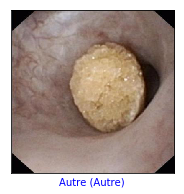

In [25]:
i = 0
plt.figure(figsize=(6,3))
plot_image(i, test_predictions, test_labels, test_images)

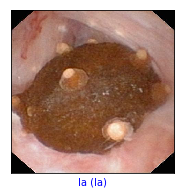

In [26]:
i = 10
plt.figure(figsize=(6,3))
plot_image(i, test_predictions, test_labels, test_images)

Let's plot several images with their predictions. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percent (out of 100) for the predicted label. Note that it can be wrong even when very confident. 

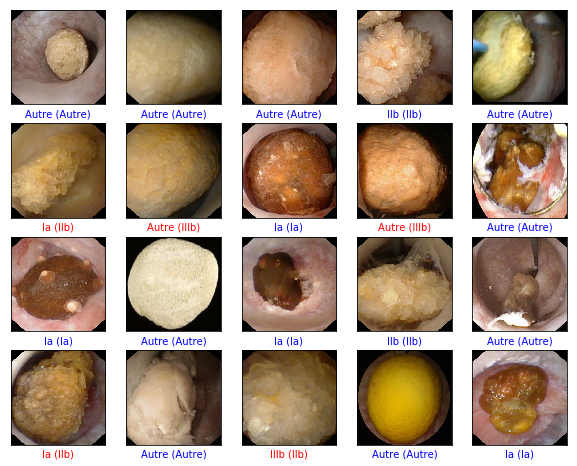

In [27]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 4
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, num_cols, i+1)
  plot_image(i, test_predictions, test_labels, test_images)


Finally, use the trained model to make a prediction about a single image. 

In [28]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(500, 500, 3)


`tf.keras` models are optimized to make predictions on a *batch*, or collection, of examples at once. So even though we're using a single image, we need to add it to a list:

In [29]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 500, 500, 3)


Now predict the image:

In [30]:
predictions_single = pipeline.predict(model.predict([img])[0].flatten().reshape(1, -1))

print(predictions_single)

[3]


# Save the model

In [ ]:
import datetime
from joblib import dump

now = datetime.datetime.now()
dump(pipeline, "./models/" + type_of_vue + "_" + "{:1.3f}".format(test_acc) + "_" + str(now))